In [7]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import polars as pl

data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-06-28,30696.560547,30703.279297,29921.822266,30086.246094,30086.246094,14571500779
2023-06-29,30086.187500,30796.250000,30057.203125,30445.351562,30445.351562,13180860821
2023-06-30,30441.353516,31256.863281,29600.275391,30477.251953,30477.251953,26387306197


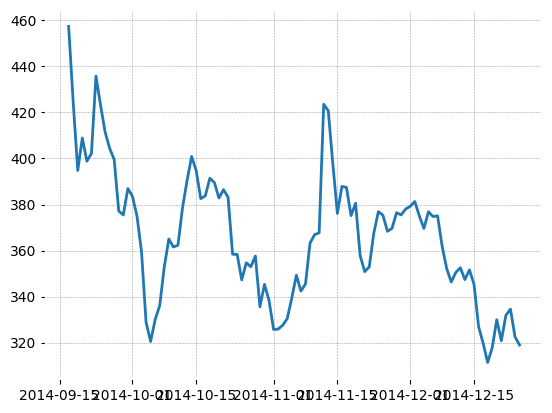

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2014-12-21,329.542999,329.628998,318.903015,320.842987,320.842987,15207600
2014-12-22,321.067993,334.117004,320.424988,331.885986,331.885986,22315100
2014-12-23,332.016998,336.286987,329.601990,334.571991,334.571991,16574200


In [76]:
df = data[0:100]
plt.plot(df.index, df.Close)
plt.show()
df

In [9]:
fig = go.Figure(data=go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'))

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()

In [10]:
# Previous and Next data chaining
# df.Low.rolling(5).min()
#df.Low.rolling(5, center=True).min()  # fractal бодохын тулд өмнөх утгуудыг агуулсан хэсгээс бодно

supports = df[df.Low == df.Low.rolling(8, center=True).min()].Low
resistances = df[df.High == df.High.rolling(8, center=True).max()].High
# merge them into one list
levels = pd.concat([supports, resistances])
levels


Date
2014-09-29    372.239990
2014-10-05    289.295990
2014-10-25    342.877014
2014-11-02    320.626007
2014-11-21    344.112000
2014-11-28    358.454987
2014-12-11    338.763000
2014-12-18    304.231995
2014-09-23    441.557007
2014-10-09    382.726013
2014-10-14    411.697998
2014-11-13    457.092987
2014-11-25    394.700989
dtype: float64

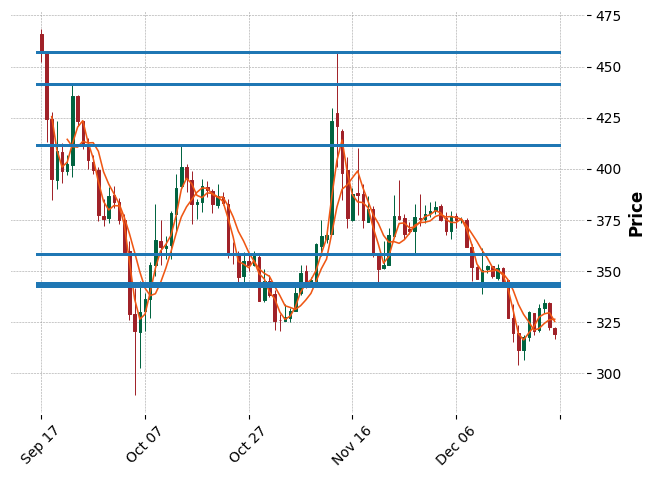

In [5]:
clean_levels = levels[abs(levels.diff() > 10)]
mpf.plot(df, type='candle', hlines=clean_levels.to_list(), style='charles', mav=(3, 6))

In [94]:
# 2 tsegiin hoorond find diff for each step
def find_diff_steps(datapoints):
    top_max = datapoints.max()
    top_min = datapoints.min()
    top_diff = top_max - top_min
    numrange = len(datapoints)
    diff_step = top_diff/numrange
    return diff_step

In [63]:
def slope_line(data: np.array):
    # find line of best fit (least squared) 
    # coefs[0] = slope,  coefs[1] = intercept 
    x = np.arange(len(data))
    # m=slope, b=intercept
    m,b = np.polyfit(x, data, 1)

    # Get points of line.
    # line_points = coefs[0] * new_x + coefs[1]

    return m,b

RESISTANCE until NOW

In [108]:
today = df[(df.index > resistance_points.index[0])]
today.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-23,332.016998,336.286987,329.601990,334.571991,334.571991,16574200
2014-12-24,334.385010,334.740997,321.356995,322.533997,322.533997,15092300
2014-12-25,322.286011,322.670013,316.958008,319.007996,319.007996,9883640


In [124]:
supports = df[df.Low == df.Low.rolling(8, center=True).min()].Low
resistances = df[df.High == df.High.rolling(8, center=True).max()].High
support_points = supports.sort_values(ascending=True).head(2)
resistance_points = resistances.sort_values(ascending=True).tail(2)
# resistance coefficients
res_slope, res_intercept = slope_line(resistance_points)

# resistance tred detection
res_ascending = True
today = df[(df.index > resistance_points.index[0])]
numrange = len(today)
x_values = []
y_values = []
diff_step = find_diff_steps(resistance_points)
y = resistance_points[0]

if res_slope > 0:
    print("Ascending")
    for i in range(0,numrange):
        y = y + diff_step
        y_values.append(y)
        x_values.append(i)
elif res_slope < 0:
    res_ascending = False
    for i in range(0,numrange):
        y = y - diff_step
        y_values.append(y)
        x_values.append(i)
    print("Descending")

print("Resistance ascending", res_ascending)
print("Diff points", diff_steps)


Resistance ascending True
Diff points 0.3107196044921875


Assign RESISTANCE values to Dataframe

In [ ]:
# LAST High Pointoos hoish 10 unit
filtered = df[(df.index < resistance_points.index[1]) & (df.index > resistance_points.index[0])]
# len(filtered)
x_index = filtered.index
x_values = []
y_values = []
# numrange = len(filtered)
numrange = len(today)
top_max = resistance_points.max()
top_min = resistance_points.min()
top_diff = top_max - top_min
diff_step = top_diff/numrange
diff_step

y = top_min
if res_slope
for i in range(0,numrange):
    y = y + diff_step
    y_values.append(y)
    x_values.append(i)

# m,b = np.polyfit(x_values, y_values, 1)
m,b = np.polyfit(resistance_points.index, resistance_points, 1)
m = -2

# determine trend slope direction
ascending = True
if m > 0:
    print("Ascending")
elif m < 0:
    ascending = False
    print("Descending")

# ============= 10 point next ========
# for i in range(numrange,numrange+10):
#     y = y + diff_step
#     y_values.append(y)
#     x_values.append(i)
# x_values
# today = df[(df.index < resistance_points.index[1]) & (df.index > resistance_points.index[0])]

DatetimeIndex(['2014-09-23', '2014-11-25'], dtype='datetime64[ns]', name='Date', freq=None)

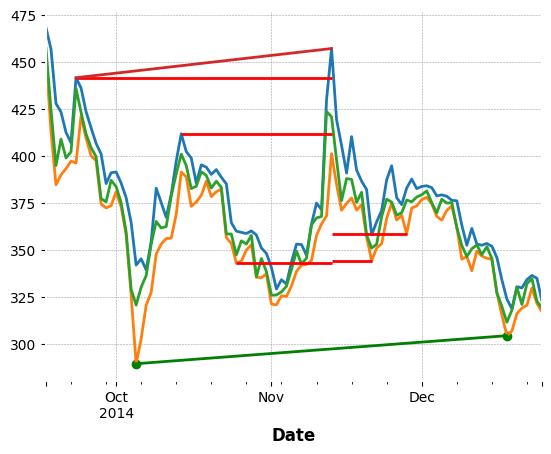

In [123]:
# MATPLOTLIB
clean_levels = levels[abs(levels.diff() > 0)]
first_point = resistances.head(1)
last_point = resistances.tail(1)
top_points = pd.concat([first_point, last_point])

df.High.plot()
df.Low.plot()
df.Close.plot()
plt.hlines(clean_levels, xmin=clean_levels.index, xmax=clean_levels.index[-1], colors='red')
# plt.scatter(x_index,y_values, color="b")
# plt.scatter(resistance_points.index, resistance_points, color='r')
plt.scatter(support_points.index, support_points, color="g")
# plt.scatter(top_points.index, top_points, color="y")
# plt.plot(top_points.index, top_points, color="y")
plt.plot(resistance_points.index, resistance_points)
plt.plot(support_points.index, support_points, color="g")
top_points.index

In [432]:
# with indicator

import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'),
                                    go.Scatter(x=df.index, y=[450]*len(df), line=dict(color='red', width=2), name="Support and Resistance"),
                                    go.Scatter(x=df.index, y=support_points, line=dict(color='green', width=2), name="Support and Resistance"),
                                    go.Scatter(x=df.index, y=resistances, mode="markers", marker=dict(size=5, color="MediumPurple"), name="Sell"),
                                    go.Scatter(x=df.index, y=supports, mode="markers", marker=dict(size=5, color="Orange"), name="Buy")])

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()

POLARS
update row